In [ ]:
!pip install langgraph  langsmith langchain langchain_groq langchain_community

INFO: pip is looking at multiple versions of langchain-groq to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installati

In [ ]:
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.0 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=f94d7f005e0d21ca866833ac1bd25f2d17848a20406ce196ede03223157f5c0e
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=dc449b6e0ba0f98c0c23d5fd1fc1f7ce6227ea765f7fdc5bf4c34c92d035b813
  Stored in directory: /root/.cache/pip/wheels/03/f5/1a/23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built wikipedia sgmllib3k


In [ ]:
from typing import Annotated  ##manage state of langgraphs
from typing_extensions import TypedDict

In [ ]:
##working with tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## arxiv and wikipedia tool

arxiv_wrapper= ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=100)
api_wrapper= WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=100)

arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

In [ ]:
wiki_tool.invoke("who is shahrukh khan")

'Page: Shah Rukh Khan\nSummary: Shahrukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), pop'

In [ ]:
arxiv_tool.invoke("attention all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of"

In [ ]:
tools=[wiki_tool]

In [ ]:
from langgraph.graph.message import add_messages
##langgraph application
## It will control entire state management
class State(TypedDict):
  #Message have the type "list".The add_message function
  # in the annotation defines how this state key should be updated
  #(in this case ,it appends messages to the list ,rather than overwriting them)
  messages:Annotated[list,add_messages]





In [ ]:
from langgraph.graph import StateGraph,START,END

In [ ]:
graph_builder=StateGraph(State)

In [ ]:
from langchain_groq import ChatGroq

In [ ]:
from google.colab import userdata
groq_api_key=userdata.get('GROQ_API_KEY')


In [ ]:
llm=ChatGroq(groq_api_key=groq_api_key,model="llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7bfce59f9190>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7bfce58bbcb0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
llm_with_tools=llm.bind(tools=tools)


In [ ]:
##define chatbot
def chatbot(state:State):
  return{"messages":[llm_with_tools.invoke(state["messages"])]}

In [ ]:
from langgraph.prebuilt import ToolNode,tools_condition

In [ ]:
##to create flow of execution
graph_builder=StateGraph(State) # Re-initialize the graph builder
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")


## to add tool node
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)
graph_builder.add_conditional_edges("chatbot",tools_condition)

graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [ ]:
graph=graph_builder.compile()

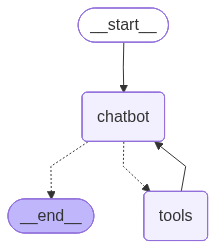

In [ ]:
## To display the graph
from IPython.display import Image , display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass


In [ ]:
user_input="Hii there! ,my name is John"

events=graph.stream(
    {"messages":[("user",user_input)]},stream_mode="values"

)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hii there! ,my name is John


PydanticSerializationError: Unable to serialize unknown type: <class 'module'>